In [2]:
import os
import nibabel as nib
import numpy as np
import gzip
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
import random
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from scipy.ndimage import binary_erosion, binary_dilation, label, gaussian_filter
import nibabel as nib
import SimpleITK as sitk
from scipy import ndimage
from skimage import morphology
import matplotlib.pyplot as plt
import zipfile

In [3]:
ct_directory = '/kaggle/input/brain-ct50/label_192/images'  
gt_directory = '/kaggle/input/brain-ct50/label_192/ground_truths'  
output_directory = '/kaggle/working/output_directory'  
os.makedirs('/kaggle/working/patches', exist_ok=True)
os.makedirs(output_directory, exist_ok=True)

In [ ]:
# Create necessary directories
os.makedirs(output_directory, exist_ok=True)
train_ct_dir = os.path.join(output_directory, 'train_ct')
train_gt_dir = os.path.join(output_directory, 'train_gt')
test_ct_dir = os.path.join(output_directory, 'test_ct')
test_gt_dir = os.path.join(output_directory, 'test_gt')

for dir_path in [train_ct_dir, train_gt_dir, test_ct_dir, test_gt_dir]:
    os.makedirs(dir_path, exist_ok=True)

# List all files in the CT and ground truth directories
ct_files = sorted([f for f in os.listdir(ct_directory) if os.path.isfile(os.path.join(ct_directory, f))])
gt_files = sorted([f for f in os.listdir(gt_directory) if os.path.isfile(os.path.join(gt_directory, f))])

# Ensure the number of CT files matches the number of ground truth files
assert len(ct_files) == len(gt_files), "Mismatch between the number of CT and ground truth files."

# Split into train and test sets (80-20 split)
train_ct, test_ct, train_gt, test_gt = train_test_split(ct_files, gt_files, test_size=0.2, random_state=42)

# Function to copy files
def copy_files(files, src_dir, dst_dir):
    for file in files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

# Copy CT and ground truth files to respective train and test directories
copy_files(train_ct, ct_directory, train_ct_dir)
copy_files(train_gt, gt_directory, train_gt_dir)
copy_files(test_ct, ct_directory, test_ct_dir)
copy_files(test_gt, gt_directory, test_gt_dir)

print(f"Dataset split and organized successfully!")
#print(f"Train CT: {len(train_ct)}, Train GT: {len(train_gt)}")
#print(f"Test CT: {len(test_ct)}, Test GT: {len(test_gt)}")


In [6]:
import os
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import random

def load_image(file_path):
    """Load a medical image and return as numpy array."""
    return sitk.GetArrayFromImage(sitk.ReadImage(file_path))

def save_patch(patch, output_path):
    """Save a patch as .nii.gz file."""
    img = sitk.GetImageFromArray(patch)
    sitk.WriteImage(img, output_path)

def validate_hemorrhage_patch(gt_patch, min_hemorrhage_percentage=0.10):
    """
    Validate if the patch contains sufficient hemorrhage pixels with stricter criteria.
    """
    hemorrhage_percentage = np.sum(gt_patch > 0) / gt_patch.size
    
    # Check if hemorrhage is well-distributed (not just at edges)
    center_region = gt_patch[gt_patch.shape[0]//4:3*gt_patch.shape[0]//4,
                           gt_patch.shape[1]//4:3*gt_patch.shape[1]//4,
                           gt_patch.shape[2]//4:3*gt_patch.shape[2]//4]
    center_percentage = np.sum(center_region > 0) / center_region.size
    
    return hemorrhage_percentage >= min_hemorrhage_percentage and center_percentage > 0.05

def extract_patches(ct_path, gt_path, output_base_dir, patch_size=(16, 32, 32), patches_per_class=100):
    """Extract balanced patches with improved validation."""
    # Create output directories
    ct_output_dir = os.path.join(output_base_dir, 'patches', 'CT')
    gt_output_dir = os.path.join(output_base_dir, 'patches', 'GT')
    os.makedirs(ct_output_dir, exist_ok=True)
    os.makedirs(gt_output_dir, exist_ok=True)

    # Load and normalize CT image
    ct_img = load_image(ct_path)
    ct_img = np.clip(ct_img, -100, 200)  # Window for better brain tissue contrast
    ct_img = (ct_img - ct_img.min()) / (ct_img.max() - ct_img.min())
    
    gt_img = load_image(gt_path)

    # Get dimensions
    depth, height, width = ct_img.shape
    d, h, w = patch_size

    if depth < d or height < h or width < w:
        print(f"Warning: Image {Path(ct_path).name} is too small for patch size {patch_size}")
        print(f"Image size: {ct_img.shape}")
        return

    # Convert multi-class to binary
    gt_binary = (gt_img > 0).astype(np.uint8)

    # Calculate valid ranges
    valid_z_range = depth - d + 1
    valid_y_range = height - h + 1
    valid_x_range = width - w + 1

    # Find hemorrhage patches with center focus
    hemorrhage_positions = []
    stride = max(1, min(valid_z_range, valid_y_range, valid_x_range) // 20)  # Smaller stride
    
    # First pass: find all potential hemorrhage centers
    for z in range(0, valid_z_range, stride):
        for y in range(0, valid_y_range, stride):
            for x in range(0, valid_x_range, stride):
                patch = gt_binary[z:z+d, y:y+h, x:x+w]
                if validate_hemorrhage_patch(patch):
                    # Calculate hemorrhage centroid in this patch
                    coords = np.where(patch > 0)
                    if len(coords[0]) > 0:
                        center_z = z + int(np.mean(coords[0]))
                        center_y = y + int(np.mean(coords[1]))
                        center_x = x + int(np.mean(coords[2]))
                        
                        # Adjust position to center the hemorrhage
                        new_z = max(0, min(valid_z_range - 1, center_z - d//2))
                        new_y = max(0, min(valid_y_range - 1, center_y - h//2))
                        new_x = max(0, min(valid_x_range - 1, center_x - w//2))
                        
                        hemorrhage_positions.append((new_z, new_y, new_x))

    # Find normal patches away from hemorrhage regions
    normal_positions = []
    max_attempts = 2000  # Increased attempts
    attempts = 0
    
    # Create hemorrhage distance map for better normal patch selection
    hemorrhage_mask = np.zeros_like(gt_binary)
    for z, y, x in hemorrhage_positions:
        hemorrhage_mask[z:z+d, y:y+h, x:x+w] = 1

    while len(normal_positions) < patches_per_class and attempts < max_attempts:
        z = random.randint(0, valid_z_range - 1)
        y = random.randint(0, valid_y_range - 1)
        x = random.randint(0, valid_x_range - 1)
        
        # Check if patch is far from hemorrhage regions
        if np.sum(hemorrhage_mask[z:z+d, y:y+h, x:x+w]) == 0:
            patch = gt_binary[z:z+d, y:y+h, x:x+w]
            if np.sum(patch) == 0:
                normal_positions.append((z, y, x))
        attempts += 1

    if len(hemorrhage_positions) == 0:
        print(f"Warning: No hemorrhage patches found in {Path(ct_path).name}")
        return

    # Sample positions
    num_hemorrhage_patches = min(patches_per_class, len(hemorrhage_positions))
    num_normal_patches = min(patches_per_class, len(normal_positions))
    
    hemorrhage_samples = random.sample(hemorrhage_positions, num_hemorrhage_patches)
    normal_samples = random.sample(normal_positions, num_normal_patches)

    print(f"Found {len(hemorrhage_positions)} hemorrhage positions and {len(normal_positions)} normal positions")
    print(f"Extracting {num_hemorrhage_patches} hemorrhage patches and {num_normal_patches} normal patches")

    # Extract and save patches
    for class_name, positions in [('hemorrhage', hemorrhage_samples), ('normal', normal_samples)]:
        for idx, pos in enumerate(positions):
            z, y, x = pos
            
            # Extract patches
            ct_patch = ct_img[z:z+d, y:y+h, x:x+w]
            gt_patch = gt_binary[z:z+d, y:y+h, x:x+w]

            # Additional validation for hemorrhage patches
            if class_name == 'hemorrhage' and not validate_hemorrhage_patch(gt_patch):
                continue

            # Generate filenames
            base_filename = f"{Path(ct_path).stem}_{class_name}_{idx}"
            ct_output_path = os.path.join(ct_output_dir, f"{base_filename}.nii.gz")
            gt_output_path = os.path.join(gt_output_dir, f"{base_filename}.nii.gz")

            # Save patches
            save_patch(ct_patch, ct_output_path)
            save_patch(gt_patch, gt_output_path)

def process_all_images(ct_directory, gt_directory, output_directory, patches_per_class=50):
    """Process all images in the specified directories."""
    ct_files = [f for f in os.listdir(ct_directory) if f.endswith('.nii')]
    gt_files = [f for f in os.listdir(gt_directory) if f.endswith('.nii')]
    
    for ct_file, gt_file in zip(ct_files, gt_files):
        print(f"Processing {ct_file}")
        ct_path = os.path.join(ct_directory, ct_file)
        gt_path = os.path.join(gt_directory, gt_file)
        
        extract_patches(
            ct_path=ct_path,
            gt_path=gt_path,
            output_base_dir=output_directory,
            patches_per_class=patches_per_class
        )
        print(f"Completed {ct_file}")

# Define directories
ct_directory = '/kaggle/working/output_directory/train_ct'  # CT images directory
gt_directory = '/kaggle/working/output_directory/train_gt'  # Ground Truth directory
output_directory = '/kaggle/working'  # Output directory

# Process all images
process_all_images(ct_directory, gt_directory, output_directory, patches_per_class=50)


Processing ID_4e227c9c_ID_d8607fa88e.nii
Found 24724 hemorrhage positions and 50 normal positions
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_4e227c9c_ID_d8607fa88e.nii
Processing ID_02f779fb_ID_c4d7f33559.nii
Found 91800 hemorrhage positions and 50 normal positions
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_02f779fb_ID_c4d7f33559.nii
Processing ID_6bb6dd02_ID_dd6370b417.nii
Found 609 hemorrhage positions and 50 normal positions
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_6bb6dd02_ID_dd6370b417.nii
Processing ID_39702b69_ID_167ab8c629.nii
Found 8115 hemorrhage positions and 50 normal positions
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_39702b69_ID_167ab8c629.nii
Processing ID_4a16396b_ID_1f3e0c2c5c.nii
Found 152257 hemorrhage positions and 50 normal positions
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_4a16396b_ID_1f3e0c2c5c.nii
Processing ID_196704db_ID_4eb6296376.

In [7]:
def count_files_by_class(directory):

    normal_count = 0
    hemorrhage_count = 0
    
    for filename in os.listdir(directory):
        if "normal" in filename.lower():
            normal_count += 1
        elif "hemorrhage" in filename.lower():
            hemorrhage_count += 1
    
    return {"normal": normal_count, "hemorrhage": hemorrhage_count}

# Paths to CT and GT directories
ct_dir = '/kaggle/working/patches/CT'
gt_dir = '/kaggle/working/patches/GT'

# Count files in CT directory
ct_counts = count_files_by_class(ct_dir)
print(f"CT Directory - Normal: {ct_counts['normal']}, Hemorrhage: {ct_counts['hemorrhage']}")

# Count files in GT directory
gt_counts = count_files_by_class(gt_dir)
print(f"GT Directory - Normal: {gt_counts['normal']}, Hemorrhage: {gt_counts['hemorrhage']}")


CT Directory - Normal: 1450, Hemorrhage: 1447
GT Directory - Normal: 1450, Hemorrhage: 1447


In [ ]:
import os
import random
import SimpleITK as sitk
import matplotlib.pyplot as plt

def load_image(file_path):

    return sitk.GetArrayFromImage(sitk.ReadImage(file_path))

def visualize_random_hemorrhage_patches(ct_dir, gt_dir, num_patches=3):

    # Get all hemorrhage files
    ct_files = [f for f in os.listdir(ct_dir) if "hemorrhage" in f.lower()]
    gt_files = [f for f in os.listdir(gt_dir) if "hemorrhage" in f.lower()]
    
    # Ensure the number of files matches between CT and GT directories
    assert len(ct_files) == len(gt_files), "Mismatch between CT and GT hemorrhage files."
    
    # Select random files
    selected_files = random.sample(ct_files, min(num_patches, len(ct_files)))
    
    # Visualize patches
    for file in selected_files:
        ct_path = os.path.join(ct_dir, file)
        gt_path = os.path.join(gt_dir, file)
        
        # Load CT and GT patches
        ct_patch = load_image(ct_path)
        gt_patch = load_image(gt_path)
        
        # Plot the patches
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(ct_patch[ct_patch.shape[0] // 2], cmap="gray")  # Show middle slice
        axes[0].set_title(f"CT Patch: {file}")
        axes[0].axis("off")
        
        axes[1].imshow(gt_patch[gt_patch.shape[0] // 2], cmap="gray")  # Show middle slice
        axes[1].set_title(f"GT Patch: {file}")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

# Paths to CT and GT directories
ct_dir = '/kaggle/working/patches/CT'
gt_dir = '/kaggle/working/patches/GT'

# Visualize random hemorrhage patches
visualize_random_hemorrhage_patches(ct_dir, gt_dir, num_patches=3)


In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Binary Cross-Entropy (built-in)
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Ensure type compatibility
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure type compatibility
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Apply threshold to the predictions (binarize)
    y_pred_f = K.cast(K.greater_equal(y_pred_f, 0.5), tf.float32)  # Convert prob to 0 or 1

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (optional if needed as a loss function)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Precision
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure type compatibility
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure type compatibility
    
    # Apply threshold to the predictions (binarize)
    y_pred_f = K.cast(K.greater_equal(y_pred, 0.5), tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred_f)
    
    true_positives = K.sum(y_true_f * y_pred_f)
    predicted_positives = K.sum(y_pred_f)
    
    return true_positives / (predicted_positives + K.epsilon())

# Recall
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure type compatibility
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure type compatibility
    
    # Apply threshold to the predictions (binarize)
    y_pred_f = K.cast(K.greater_equal(y_pred, 0.5), tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred_f)
    
    true_positives = K.sum(y_true_f * y_pred_f)
    possible_positives = K.sum(y_true_f)
    
    return true_positives / (possible_positives + K.epsilon())


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv3d_block(input_tensor, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation=True):
    """A convolutional block with optional activation."""
    x = layers.Conv3D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.ReLU()(x)
    return x

def residual_block(input_tensor, filters, strides=(1, 1, 1)):
    """A single residual block with optional downsampling."""
    # Shortcut connection with optional downsampling
    shortcut = conv3d_block(input_tensor, filters, kernel_size=(1, 1, 1), strides=strides, activation=False)

    # Residual path
    x = conv3d_block(input_tensor, filters, strides=strides)
    x = conv3d_block(x, filters, activation=False)

    # Add shortcut and residual path
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def up_block(input_tensor, skip_tensor, filters):
    """Upsampling block with skip connection."""
    # Upsample
    x = layers.UpSampling3D(size=(2, 2, 2))(input_tensor)

    # Concatenate with skip connection
    x = layers.Concatenate()([x, skip_tensor])

    # Apply residual block
    x = residual_block(x, filters)
    return x

def build_improved_resnet_3d(input_shape=(16, 32, 32, 1), num_classes=1):
    """Builds an improved 3D ResNet model with U-Net-style architecture."""
    inputs = layers.Input(shape=input_shape)

    # Initial convolution
    x = conv3d_block(inputs, filters=64, kernel_size=(7, 7, 7), strides=(1, 1, 1))
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    # Encoder path with skip connections
    skip1 = residual_block(x, filters=64)  # 8x16x16
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(skip1)

    skip2 = residual_block(x, filters=128)  # 4x8x8
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(skip2)

    skip3 = residual_block(x, filters=256)  # 2x4x4
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(skip3)

    # Bridge
    x = residual_block(x, filters=512)  # 1x2x2
    x = residual_block(x, filters=512)

    # Decoder path
    x = up_block(x, skip3, 256)  # 2x4x4
    x = up_block(x, skip2, 128)  # 4x8x8
    x = up_block(x, skip1, 64)   # 8x16x16

    # Final upsampling
    x = layers.UpSampling3D(size=(2, 2, 2))(x)  # 16x32x32

    # Final convolution layers
    x = conv3d_block(x, filters=32, kernel_size=(3, 3, 3))
    x = conv3d_block(x, filters=16, kernel_size=(3, 3, 3))

    # Output layer
    outputs = layers.Conv3D(num_classes, kernel_size=(1, 1, 1), activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Custom metrics
def dice_coefficient(y_true, y_pred, smooth=1.0):
    """Calculate Dice coefficient."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Example usage
input_shape = (16, 32, 32, 1)  # Adjusted for typical medical image sizes
model = build_improved_resnet_3d(input_shape=input_shape, num_classes=1)

# Compile model with additional metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient]
)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16, 32, 32, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 16, 32, 32, 64) │         21,952 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 32, 32, 64) │            256 │ conv3d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 32, 32, 64) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 16, 32, 32, 64) │              0 │ re_lu[0][0]            │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 16, 32, 32, 64) │        110,592 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 32, 32, 64) │            256 │ conv3d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 16, 32, 32, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 16, 32, 32, 64) │        110,592 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 16, 32, 32, 64) │          4,096 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 32, 32, 64) │            256 │ conv3d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 32, 32, 64) │            256 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 32, 32, 64) │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 16, 32, 32, 64) │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 16, 32, 32,     │        221,184 │ re_lu_2[0][0]          │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 16, 32, 32,     │            512 │ conv3d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 14,366,145 (54.80 MB)

 Trainable params: 14,360,257 (54.78 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
import os
import numpy as np
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Directories for train CT and GT patches
train_ct_dir = '/kaggle/working/patches/CT'
train_gt_dir = '/kaggle/working/patches/GT'

# Function to load patches
def load_patches(ct_dir, gt_dir):
    ct_files = sorted([os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.endswith('.nii.gz')])
    gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.nii.gz')])

    ct_patches = []
    gt_patches = []

    for ct_file, gt_file in zip(ct_files, gt_files):
        # Load the CT and GT patches
        ct_patch = sitk.GetArrayFromImage(sitk.ReadImage(ct_file)).astype(np.float32)
        gt_patch = sitk.GetArrayFromImage(sitk.ReadImage(gt_file)).astype(np.uint8)
        
        # Ensure ground truth is binary
        gt_patch = (gt_patch > 0).astype(np.uint8)

        ct_patches.append(ct_patch)
        gt_patches.append(gt_patch)

    return np.array(ct_patches), np.array(gt_patches)
def plot_training_history(history):
    """
    Plot training history including loss, accuracy, and Dice coefficient
    """
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    
    # Plot training & validation accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    ax2.grid(True)
    
    # Plot training & validation Dice coefficient
    ax3.plot(history.history['dice_coefficient'], label='Training Dice')
    ax3.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    ax3.set_title('Dice Coefficient')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Dice Coefficient')
    ax3.legend(loc='lower right')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_history.png')
    plt.show()
    
    # Print best metrics
    best_val_dice = max(history.history['val_dice_coefficient'])
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    
    print("\nBest Validation Metrics:")
    print(f"Dice Coefficient: {best_val_dice:.4f}")
    print(f"Accuracy: {best_val_acc:.4f}")
    print(f"Loss: {best_val_loss:.4f}")
# Load all patches
ct_patches, gt_patches = load_patches(train_ct_dir, train_gt_dir)

# Reshape patches to add channel dimension
ct_patches = np.expand_dims(ct_patches, axis=-1)  
gt_patches = np.expand_dims(gt_patches, axis=-1)  )

# Split into training and validation sets
ct_train, ct_val, gt_train, gt_val = train_test_split(ct_patches, gt_patches, test_size=0.2, random_state=42)

print(f"Training data shape: {ct_train.shape}, {gt_train.shape}")
print(f"Validation data shape: {ct_val.shape}, {gt_val.shape}")

# Callbacks
callbacks = [
    ModelCheckpoint(
        filepath='/kaggle/working/best_3d_resnet_model.keras',  
        save_best_only=True,
        monitor='val_dice_coefficient',  
        mode='max',  
        verbose=1
    ),
    EarlyStopping(
        monitor='val_dice_coefficient',  
        patience=7,  
        mode='max',  
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.5,  
        patience=5,  
        verbose=1
    )
]

# Build the 3D ResNet model (using your updated build function)
input_shape = (ct_train.shape[1], ct_train.shape[2], ct_train.shape[3], 1)  
num_classes = 1  # Binary classification

# Build the model
resnet_model = build_resnet_3d(input_shape=input_shape, num_classes=num_classes)

# Compile the model
resnet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient, precision, recall]  
)

# Fit the model
history = resnet_model.fit(
    x=ct_train,
    y=gt_train,
    validation_data=(ct_val, gt_val),
    batch_size=8,  
    epochs=50,     
    callbacks=callbacks,
    verbose=1
)

plot_training_history(history)

# Save the final model
resnet_model.save('/kaggle/working/final_3d_resnet_model.keras')

# Save history to a numpy file for later analysis if needed
np.save('/kaggle/working/training_history.npy', history.history)

Training data shape: (2317, 16, 32, 32, 1), (2317, 16, 32, 32, 1)
Validation data shape: (580, 16, 32, 32, 1), (580, 16, 32, 32, 1)
Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8799 - dice_coefficient: 0.2961 - loss: 0.3150 - precision: 0.4784 - recall: 0.2912
Epoch 1: val_dice_coefficient improved from -inf to 0.44713, saving model to /kaggle/working/best_3d_resnet_model.keras
290/290 ━━━━━━━━━━━━━━━━━━━━ 1301s 4s/step - accuracy: 0.8800 - dice_coefficient: 0.2964 - loss: 0.3147 - precision: 0.4787 - recall: 0.2914 - val_accuracy: 0.8402 - val_dice_coefficient: 0.4471 - val_loss: 0.3397 - val_precision: 0.3547 - val_recall: 0.6414 - learning_rate: 0.0010
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9289 - dice_coefficient: 0.5609 - loss: 0.1773 - precision: 0.7076 - recall: 0.4991
Epoch 2: val_dice_coefficient did not improve from 0.44713
290/290 ━━━━━━━━━━━━━━━━━━━━ 1042s 4s/step - accuracy: 0.9289 - dice_coefficient: 0.5610 - loss: 0.1773 - pr

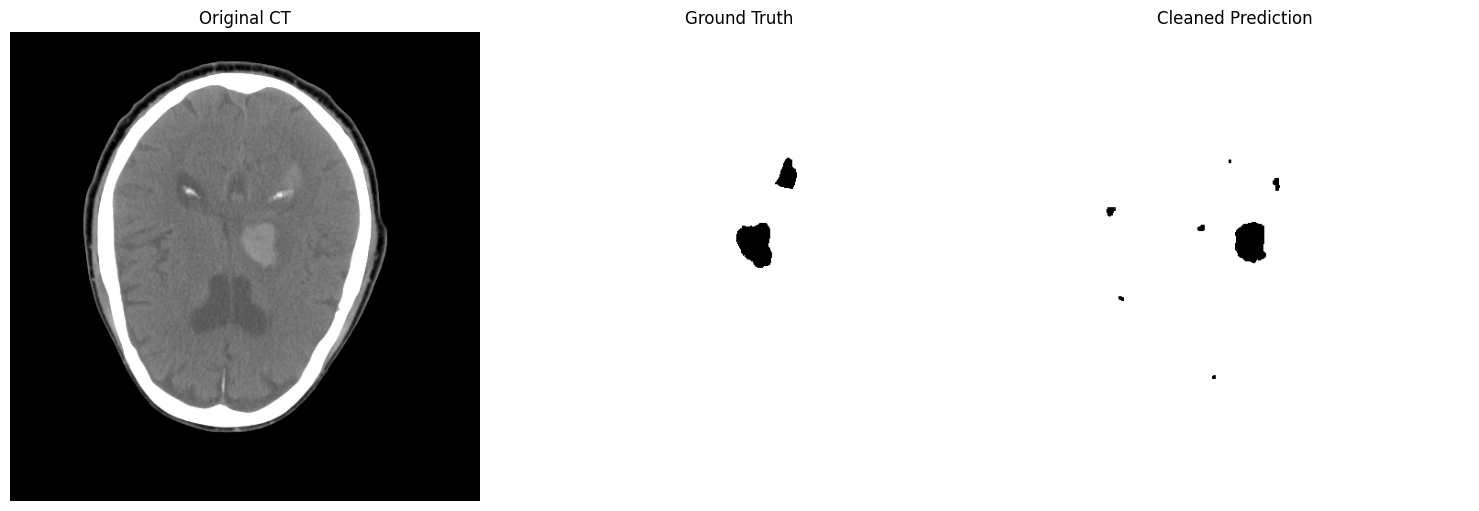

Showing slice 14 out of 28 slices


In [4]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage
from tensorflow.keras.models import load_model

def post_process_prediction(prediction, min_size=50, remove_boundary=True):
    """
    Enhanced post-processing to remove noise, boundaries, and smooth results for 3D volumes
    
    Args:
        prediction: Binary prediction volume (3D)
        min_size: Minimum size of connected components to keep
        remove_boundary: Whether to remove boundary artifacts
    """
    # Convert to binary
    binary_pred = prediction > 0.5
    
    if remove_boundary:
        # Create 3D kernel for morphological operations
        kernel = np.ones((3, 3, 3))  # 3D kernel
        
        # Remove thin structures using erosion followed by dilation
        binary_pred = ndimage.binary_erosion(binary_pred, structure=kernel, iterations=1)
        binary_pred = ndimage.binary_dilation(binary_pred, structure=kernel, iterations=1)
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_pred)
    
    # Calculate size of each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Keep only the largest components (excluding background)
    if len(component_sizes) > 1:
        size_threshold = max(min_size, np.percentile(component_sizes[1:], 50))
        too_small = component_sizes < size_threshold
        too_small[0] = False  # Don't remove background
        mask = too_small[labeled_array]
        binary_pred[mask] = False
    
    # Final smoothing with 3D kernels
    binary_pred = ndimage.binary_closing(binary_pred, structure=kernel)
    binary_pred = ndimage.binary_opening(binary_pred, structure=kernel)
    
    return binary_pred.astype(np.uint8)

def predict_patches(model, image, patch_size=(16, 32, 32)):
    """Predict on overlapping patches and reconstruct full image."""
    depth, height, width = image.shape
    d, h, w = patch_size
    
    prediction = np.zeros_like(image)
    count = np.zeros_like(image)
    
    stride_d = d // 2
    stride_h = h // 2
    stride_w = w // 2
    
    for z in range(0, depth - d + 1, stride_d):
        for y in range(0, height - h + 1, stride_h):
            for x in range(0, width - w + 1, stride_w):
                patch = image[z:z+d, y:y+h, x:x+w]
                patch = np.expand_dims(np.expand_dims(patch, axis=0), axis=-1)
                pred = model.predict(patch, verbose=0)[0, ..., 0]
                prediction[z:z+d, y:y+h, x:x+w] += pred
                count[z:z+d, y:y+h, x:x+w] += 1
    
    prediction = np.divide(prediction, count, where=count>0)
    cleaned_prediction = post_process_prediction(prediction, min_size=100)
    
    return cleaned_prediction
# Main execution code
model = load_model('/kaggle/input/best-one/best_3ds_resnet_model.keras', 
                  custom_objects={'dice_coefficient': dice_coefficient})

# Load and preprocess test image
ct_path = '/kaggle/input/brain-ct50/label_192/images/ID_0237f3c9_ID_40015688b9.nii'
gt_path = '/kaggle/input/brain-ct50/label_192/ground_truths/ID_0237f3c9_ID_40015688b9.nii'
ct_image = load_and_preprocess_image(ct_path)
gt_image = sitk.GetArrayFromImage(sitk.ReadImage(gt_path))
gt_image = (gt_image > 0).astype(np.uint8)

# Generate prediction with post-processing
prediction_binary = predict_patches(model, ct_image)

# Visualize results
middle_slice = ct_image.shape[0] // 2
plt.figure(figsize=(15, 5))

# Original CT
plt.subplot(131)
plt.imshow(ct_image[middle_slice], cmap='gray')
plt.title('Original CT')
plt.axis('off')

# Ground Truth 
plt.subplot(132)
plt.imshow(gt_image[middle_slice], cmap='binary')
plt.title('Ground Truth')
plt.axis('off')

# Cleaned Prediction
plt.subplot(133)
plt.imshow(prediction_binary[middle_slice], cmap='binary')
plt.title('Cleaned Prediction')
plt.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/cleaned_comparison_result.png')
plt.show()

print(f"Showing slice {middle_slice} out of {ct_image.shape[0]} slices")